In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from tqdm import tqdm

In [71]:
Ms = 0.5*u.solMass

deltar = 1*u.au
rmed = 10*u.au
rmin = rmed-deltar
rmax = rmed+deltar


Ncells = 1000
ris = np.linspace(rmin, rmax, Ncells+1)
r = 0.5*(ris[1:] + ris[:-1])

alpha = 1e-2
h0 = 0.040613
flaring = 0.25
# h0 = 0.05
# flaring = 0.0

sigma0 = 20*u.g/u.cm**2

particle_density = 2.65*u.g/u.cm**3
particle_size = 1e-5*u.cm

h = h0*r.to_value("au")**flaring

vK = np.sqrt(const.G*Ms/r)
OmegaK = vK/r
H = h*r
cs = h*vK

sigmag = sigma0 * r.to_value("au")**-1
rhog = sigmag / (np.sqrt(2*np.pi)*H)

tstop = particle_size*particle_density/(rhog*cs)
St = tstop * OmegaK

# Youdin & Lithwick 2007 Eq. 37
Sc = (1 + St**2)**2  / (1 + 4*St**2)

Dg = alpha*cs*H
Dd = Dg/Sc

Text(0, 0.5, 'Dd')

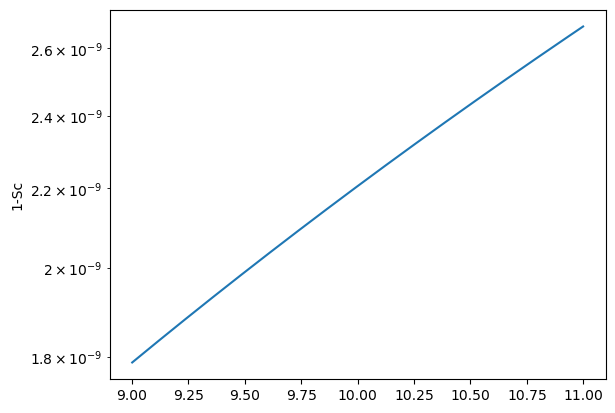

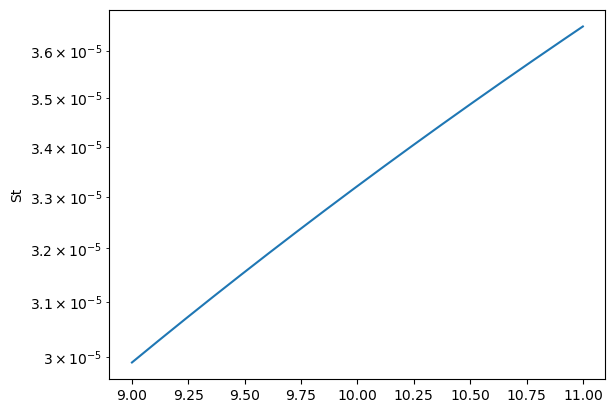

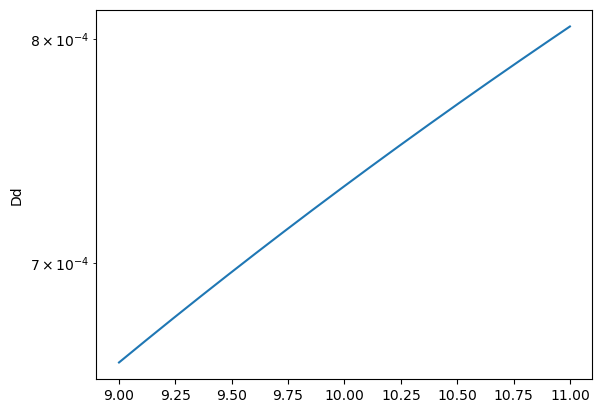

In [72]:
fig, ax = plt.subplots()
ax.plot(r, 1-Sc)
ax.set_yscale("log")
ax.set_ylabel("1-Sc")

fig, ax = plt.subplots()
ax.plot(r, St)
ax.set_yscale("log")
ax.set_ylabel("St")

fig, ax = plt.subplots()
ax.plot(r, Dd.to_value("au2/yr"))
ax.set_yscale("log")
ax.set_ylabel("Dd")

Radial advection-diffusion equation according to Charnoz et al. 2011 Eq. (28)

$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} ( -r V_r \rho_g C + r \rho_g D_d \frac{\partial C}{\partial r} )$$

with the dust concentration 

$C = \frac{\rho_d}{\rho_g}$.

$V_r$ is the gas radial velocity which is taken to be zero.

Then the equation to solves becomes the diffusion equation
$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} (r \rho_g D_d \frac{\partial C}{\partial r})$$

In [117]:
Nbound = 10
def boundaries(C):
    C[:Nbound] = 0
    C[-Nbound:] = 0
    return C

def rhs(C):
    dCdr = np.gradient(C, r, edge_order=2)
    X = r*rhog*Dd*dCdr
    dXdr = np.gradient(X, r, edge_order=2)
    return dXdr / (r*rhog)
    

100%|██████████| 100/100 [00:00<00:00, 1181.60it/s]


(9.999, 10.001)

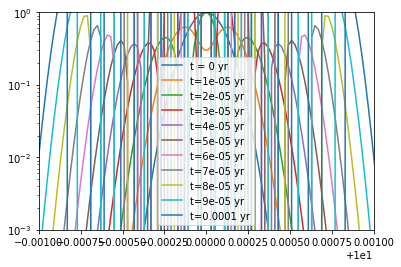

In [118]:
C = np.exp(- 0.5*(r.to_value("au") - 10)**2/(0.0001**2))

t = 0*u.yr
dt = 0.00001*u.yr
tfinal = 0.0001*u.yr

t_save = tfinal/100
N_save = int((tfinal / t_save).decompose()) + 1
times_save = np.linspace(0, tfinal, N_save)
saves = np.zeros((len(times_save), Ncells))


fig, ax = plt.subplots()

ax.plot(r, C, label = "t = 0 yr")

nplot = 0

saves[0] = C


for n in tqdm(range(N_save-1)):
    while t < times_save[n+1]:
        
        C = boundaries(C)
        dCdt = rhs(C).decompose()
        C += (dt*dCdt).decompose().value
        t += dt        
        if t > nplot*tfinal/10:
            ax.plot(r, C, label = f"t={t:.3g}")
            nplot += 1
    
    saves[n+1] = C

ax.legend()
ax.set_yscale("log")
ax.set_ylim(bottom=1e-3, top=1)
# ax.set_ylim(top=1)
dr = 1e-3
ax.set_xlim(10-dr, 10+dr)

In [28]:
sigmads = np.zeros_like(saves)
for n, C in enumerate(saves):
    rhod = C*rhog
    sigmads[n] = rhod*(np.sqrt(2*np.pi)*H)

np.save("../analytical_data/analytic_profiles", sigmads)
np.save("../analytical_data/analytic_times", times_save.to_value("yr"))
np.save("../analytical_data/analytic_radii", r.to_value("au"))

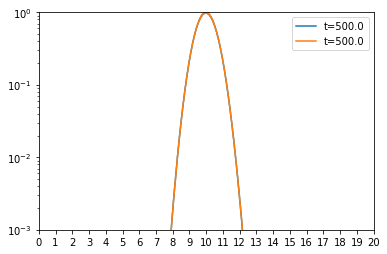

In [12]:
fig, ax = plt.subplots()

times = times_save.to_value("yr")

tplot = 2500
n = np.argmin(np.abs(times - tplot))
X = r
rhod = saves[n]
sigmad = rhod/(np.sqrt(2*np.pi)*H)
Y = sigmad / np.max(sigmad)
ax.plot(X, Y, label = f"t={times[n]}")

tplot = 5000
n = np.argmin(np.abs(times - tplot))
rhod = saves[n]
sigmad = rhod/(np.sqrt(2*np.pi)*H)
Y = sigmad / np.max(sigmad)
ax.plot(X, Y, label = f"t={times[n]}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-3,top=1)
ax.legend(loc="best")
ax.set_xlim(left=0, right=20)

ax.set_xticks(range(0,21));

Text(0, 0.5, 'rhog')

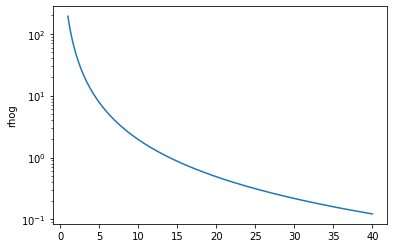

In [20]:
fig, ax = plt.subplots()
ax.plot(r, rhog)
ax.set_yscale("log")
ax.set_ylabel("rhog")

In [22]:
ls = np.load("../analytical_data/analytic_profiles.npy")
lt = np.load("../analytical_data/analytic_times.npy")
lr = np.load("../analytical_data/analytic_radii.npy")

(0.0, 20.0)

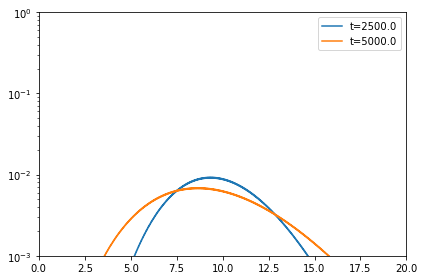

In [84]:
fig, ax = plt.subplots()

tplot = 2500
n = np.argmin(np.abs(lt - tplot))
ax.plot(rcs, ls[n], label = f"t={lt[n]}")

tplot = 5000
n = np.argmin(np.abs(lt - tplot))
ax.plot(rcs, ls[n], label = f"t={lt[n]}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-3,top=1)
ax.legend(loc="best")
ax.set_xlim(left=0, right=20)

In [86]:
lr

array([ 1.00975,  1.02925,  1.04875, ..., 39.95125, 39.97075, 39.99025])

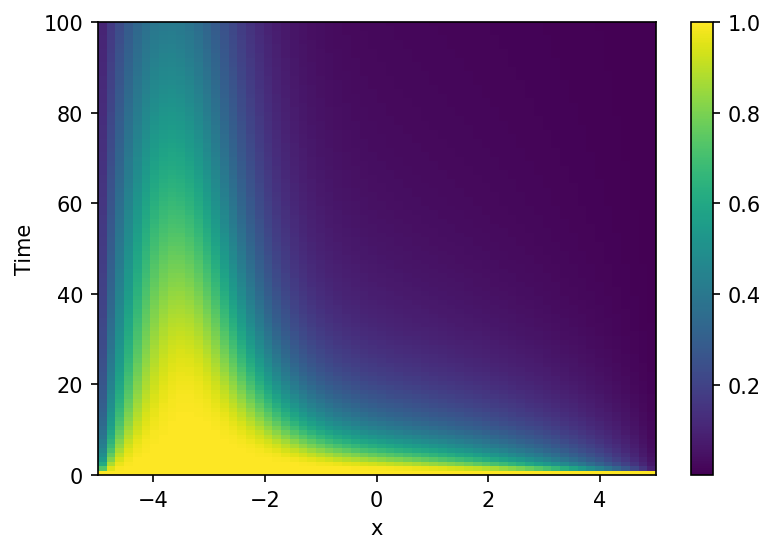

In [98]:
#!pip install py-pde h5py pandas pyfftw tqdm
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph

# Expanded definition of the PDE
diffusivity = "1.01 + tanh(x)"
term_1 = f"({diffusivity}) * laplace(c)"
term_2 = f"dot(gradient({diffusivity}), gradient(c))"
eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})


grid = CartesianGrid([[-5, 5]], 64)  # generate grid
field = ScalarField(grid, 1)  # generate initial condition

storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, 100, dt=1e-3, tracker=storage.tracker(1))  # solve the PDE

fig, ax = plt.subplots(dpi=150)

plot_kymograph(storage, ax=ax)  # visualize the result in a space-time plot

In [74]:
Ms = 0.5*u.solMass

r0 = 1*u.au
alpha = 1e-2
h0 = 0.040613
flaring = 0.25
beta = -1

H0 = h0*r0

sigmag0 = 20*u.g/u.cm**2
rhog0 = sigmag0 / (np.sqrt(2*np.pi)*H0)

particle_density = 2.65*u.g/u.cm**3
particle_size = 1e-5*u.cm

vK0 = np.sqrt(const.G*Ms/r0)
OmegaK0 = vK0/r0
cs0 = h0*vK0

ts0 = particle_density*particle_size/(rhog0*cs0)
St0 = ts0 * OmegaK0
St0 = St0.decompose().value

Dg0 = alpha*cs0*h0*r0
Dg0 = Dg0.to_value("au2/yr")

# Youdin & Lithwick 2007 Eq. 37
# Sc = (1 + St**2)**2  / (1 + 4*St**2)

In [85]:
St = f"{St0} * x**(-{beta} - {flaring})"
Sc = f"(1 + ({St})**2)**2 / (1 + 4*({St})**2)"
Dd = f"{Dg0} * x**(0.5+{flaring}) / ({Sc})"
Dd = f"{Dg0} * x**(0.5+{flaring})"

In [86]:
from sympy import latex, simplify, parse_expr
simplify(St)
# simplify(Sc)
simplify(Dd)

7.328022775513307e-5*x**0.75

In [113]:
import numba
import sympy

In [126]:
from sympy.abc import x
def numbafy(expr):
    return numba.jit(sympy.lambdify(x, parse_expr(expr), "math")) 

def plot_expr(expr):
    fig, ax = plt.subplots()
    ax.plot(r, numbafy(expr)(r.to_value("au")))
    ax.set_ylabel(expr)
    ax.set_xlabel("r")

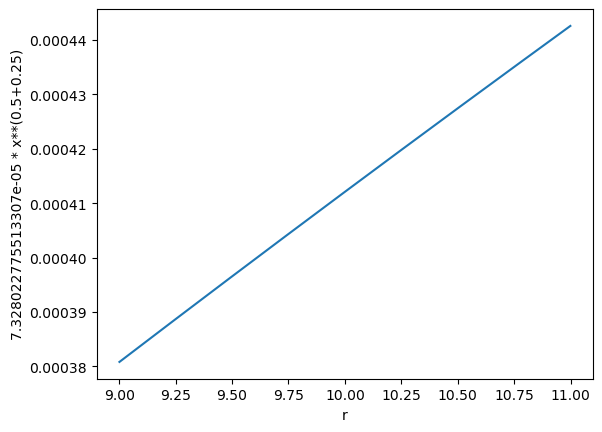

In [127]:
plot_expr(Dd)

In [118]:
#!pip install py-pde h5py pandas pyfftw tqdm
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph

# Expanded definition of the PDE
# diffusivity = "1e-2"
diffusivity = f"({Dd})"
gamma = "-1"
term_1 = f"({gamma}) / x * {diffusivity} * d_dx(c)"
term_2 = f"d_dx({diffusivity}) * d_dx(c)"
term_3 = f"{diffusivity} * laplace(c)"
rhs = f"{term_1} + {term_2} + {term_3}"
eq = PDE({"c": rhs}, bc={"value": 0})

In [129]:
simplify(term_1)


-7.328022775513307e-5*d_dx(c)/x**0.25

In [120]:
simplify(term_2)

d_dx(c)*d_dx(7.328022775513307e-5*x**0.75)

In [121]:
simplify(term_3)

7.328022775513307e-5*x**0.75*laplace(c)

Radial advection-diffusion equation according to Charnoz et al. 2011 Eq. (28)

$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} ( -r V_r \rho_g C + r \rho_g D_d \frac{\partial C}{\partial r} )$$

with the dust concentration 

$C = \frac{\rho_d}{\rho_g}$.

$V_r$ is the gas radial velocity which is taken to be zero.

Then the equation to solves becomes the diffusion equation
$$\frac{dC}{dt} = \frac{1}{\rho_g r} \frac{\partial}{\partial r} (r \rho_g D_d \frac{\partial C}{\partial r})$$

In [ ]:
#!pip install py-pde h5py pandas pyfftw tqdm
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph




# Expanded definition of the PDE
# diffusivity = "1e-2"
diffusivity = f"({Dd})"
gamma = "-1"
term_1 = f"({gamma}) / x * {diffusivity} * d_dx(c)"
term_2 = f"d_dx({diffusivity}) * d_dx(c)"
term_3 = f"{diffusivity} * laplace(c)"
rhs = f"{term_1} + {term_2} + {term_3}"
eq = PDE({"c": rhs}, bc={"value": 0})

In [135]:
Ms = 0.5*u.solMass

r0 = 1*u.au
alpha = 1e-2
h0 = 0.040613
flaring = 0.25
beta = -1

H0 = h0*r0

sigmag0 = 20*u.g/u.cm**2
rhog0 = sigmag0 / (np.sqrt(2*np.pi)*H0)

particle_density = 2.65*u.g/u.cm**3
particle_size = 1e-5*u.cm

vK0 = np.sqrt(const.G*Ms/r0)
OmegaK0 = vK0/r0
cs0 = h0*vK0

ts0 = particle_density*particle_size/(rhog0*cs0)
St0 = ts0 * OmegaK0
St0 = St0.decompose().value

Dg0 = alpha*cs0*h0*r0
Dg0 = Dg0.to_value("au2/yr")

# Youdin & Lithwick 2007 Eq. 37
# Sc = (1 + St**2)**2  / (1 + 4*St**2)

rhog0 = rhog0.to_value('solMass/au3')  
rhog = f"{rhog0} * x**{beta-flaring-1}"

St = f"{St0} * x**(-{beta} - {flaring})"
Sc = f"(1 + ({St})**2)**2 / (1 + 4*({St})**2)"
Dd = f"{Dg0} * x**(0.5+{flaring}) / ({Sc})"
Dd = f"{Dg0} * x**(0.5+{flaring} + 1)"

rhs = f"( d_dx({rhog} * x * {Dd} * d_dx(c) ) ) / ({rhog} * x)"

In [150]:
2**12

4096

/home/thomas/.local/lib/python3.10/site-packages/pde/solvers/explicit.py:176: RuntimeWarning: invalid value encountered in add
  state_data += dt * rhs_pde(state_data, t)
/home/thomas/.local/lib/python3.10/site-packages/pde/visualization/plotting.py:626: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes_image = ax.imshow(


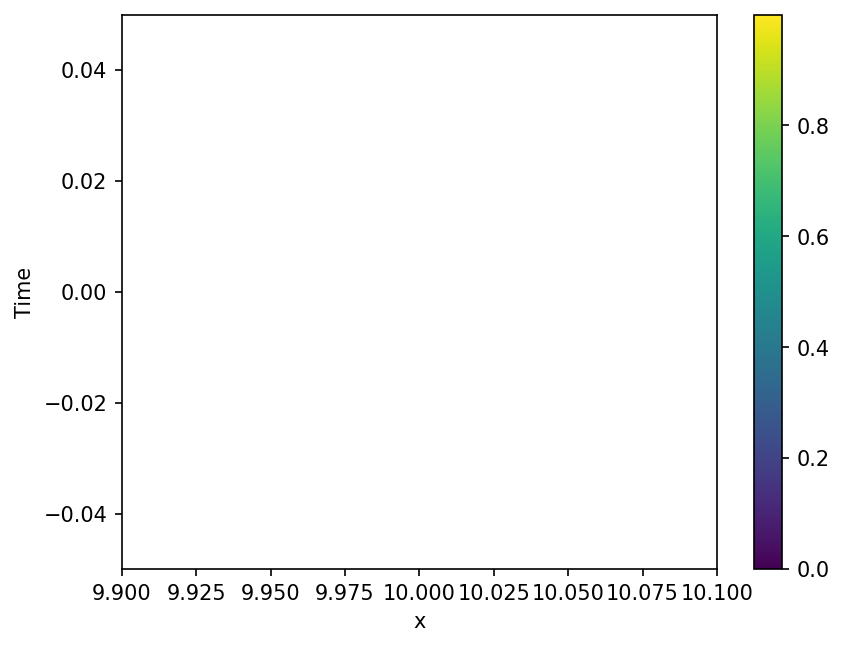

In [157]:

eq = PDE({"c": rhs}, bc={"value": 0})

dr = 0.1
grid = CartesianGrid([[10-dr, 10+dr]], 2**12 )  # generate grid
coords = grid.cell_coords[:,0]
dinit = np.exp(- 0.5*(grid.cell_coords[:,0]-10)**2/(0.1**2))


field = ScalarField(grid, dinit)  # generate initial condition

storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, 0.1, dt=1e-4, tracker=storage.tracker(1))  # solve the PDE

fig, ax = plt.subplots(dpi=150)

plot_kymograph(storage, ax=ax)  # visualize the result in a space-time plot

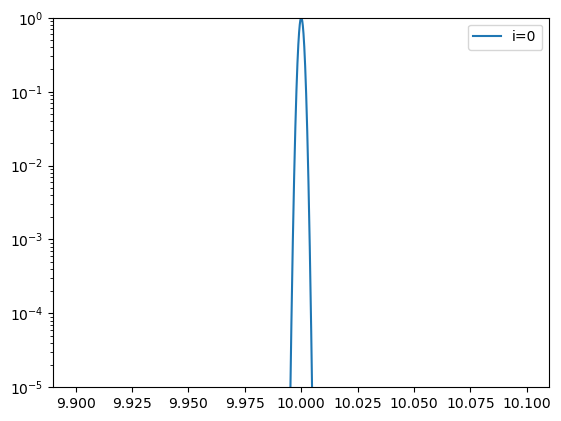

In [158]:
fig, ax = plt.subplots()
N = len(storage)
for i, f in storage.items():
    # if not i%(N//10) == 0:
    #     continue
    d = f.data
    ax.plot(coords, d, label=f"i={i}")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-5, top=1)
ax.legend()